# Import lib

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from google.colab.patches import cv2_imshow
import pickle

%matplotlib inline

# Download calibration image to calibrate camera

In [ ]:
!gdown --id 1KBIZZHepg96GBBKywPa7Cy7rL1bx_nU5
!unzip camera_cal.zip
!rm camera_cal.zip

# Download demo image

In [ ]:
!gdown --id 1E7Y0Z4bnHp775ciuhWh1z4E9yZQhOlHC -O straight_line.png

Downloading...
From: https://drive.google.com/uc?id=1E7Y0Z4bnHp775ciuhWh1z4E9yZQhOlHC
To: /content/straight_line.png
100% 1.92M/1.92M [00:00<00:00, 60.4MB/s]


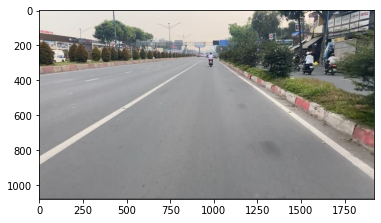

In [ ]:
demo_img = cv2.imread('/content/straight_line.png')
# demo_img = cv2.resize(demo_img, (1280,720))
demo_img = cv2.cvtColor(demo_img, cv2.COLOR_BGR2RGB)
plt.imshow(demo_img)
plt.show()

# Calibration & Distortion Correction

In [ ]:
def calibrate_camera():
  # Mapping each calibration image to number of checkerboard corners
  # Everything is (4,4) for now
  objp_dict = {1: (4,4), 2: (4,4), 3: (4,4), 4: (4,4), 5: (4,4), 6: (4,4), 7: (4,4), 8: (4,4),
		          9: (4,4), 10: (4,4), 11: (4,4), 12: (4,4), 13: (4,4), 14: (4,4), 15: (4,4), 16: (4,4),
		          17: (4,4), 18: (4,4), 19: (4,4), 20: (4,4), 21: (4,4), 22: (4,4), 23: (4,4), 24: (4,4),
		          25: (4,4), 26: (4,4), 27: (4,4), 28: (4,4)}
  # List of object points and corners for calibration
  objp_list = []
  corners_list = []

	# Go through all images and find corners
  for k in objp_dict:
    nx, ny = objp_dict[k]
    
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

		# Make a list of calibration images
    fname = '/content/camera_cal/calibration%s.jpg' % str(k)
    img = cv2.imread(fname)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
		# img = cv2.resize(img, (1920,1080))
		# Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

		# Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

		# If found, save & draw corners
    if ret == True:
			# Save object points and corresponding corners
      objp_list.append(objp)
      corners_list.append(corners)

			# Draw and display the corners
      cv2.drawChessboardCorners(rgb, (nx, ny), corners, ret)
      plt.imshow(rgb)
      plt.show()
      print('Found corners for %s' % fname)
    else:
      print('Warning: ret = %s for %s' % (ret, fname))

	# Calibrate camera and undistort a test image
  img = cv2.imread('/content/straight_line.png')
  img_size = (img.shape[1], img.shape[0])
  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp_list, corners_list, img_size,None,None)
  
  return mtx, dist

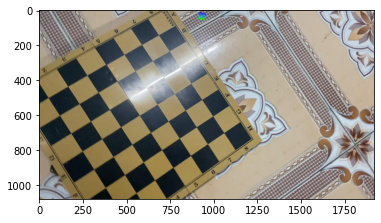

Found corners for /content/camera_cal/calibration1.jpg


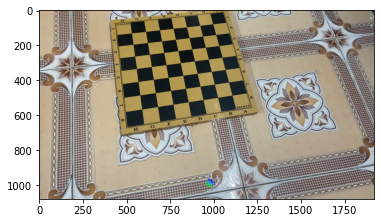

Found corners for /content/camera_cal/calibration2.jpg


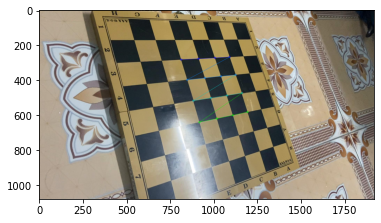

Found corners for /content/camera_cal/calibration3.jpg


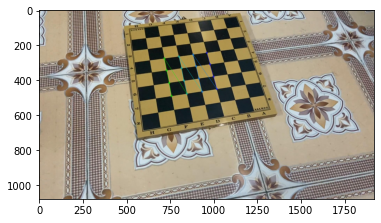

Found corners for /content/camera_cal/calibration4.jpg


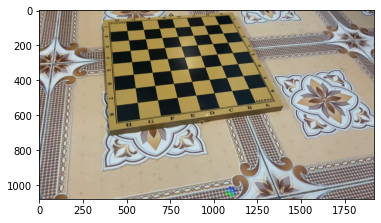

Found corners for /content/camera_cal/calibration5.jpg


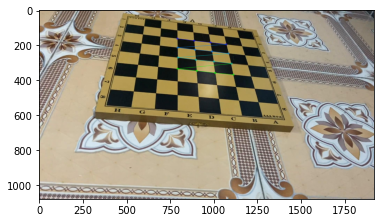

Found corners for /content/camera_cal/calibration6.jpg


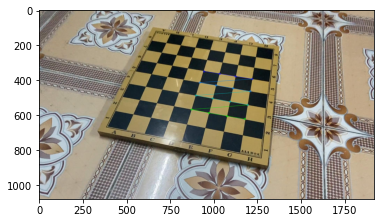

Found corners for /content/camera_cal/calibration7.jpg


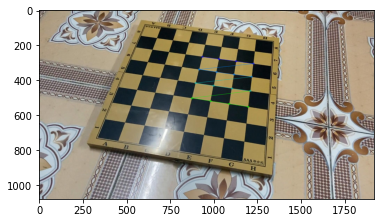

Found corners for /content/camera_cal/calibration8.jpg


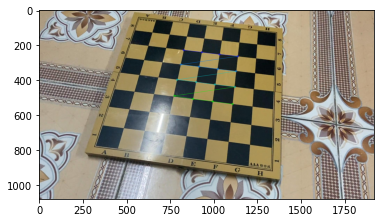

Found corners for /content/camera_cal/calibration9.jpg


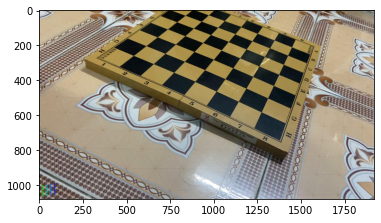

Found corners for /content/camera_cal/calibration10.jpg


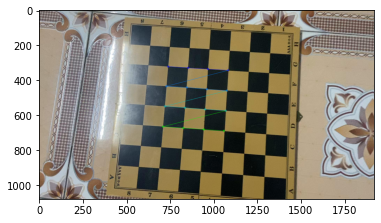

Found corners for /content/camera_cal/calibration11.jpg


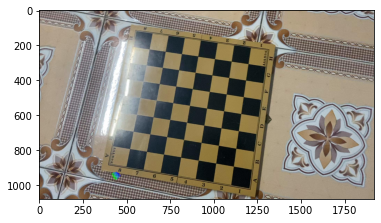

Found corners for /content/camera_cal/calibration12.jpg


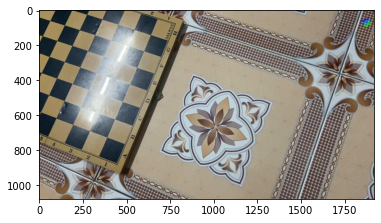

Found corners for /content/camera_cal/calibration13.jpg


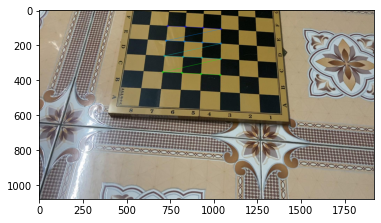

Found corners for /content/camera_cal/calibration14.jpg


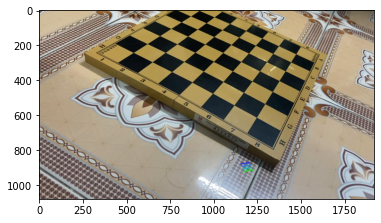

Found corners for /content/camera_cal/calibration15.jpg


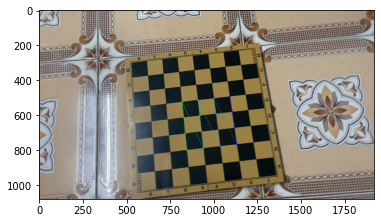

Found corners for /content/camera_cal/calibration16.jpg


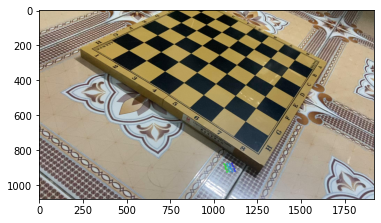

Found corners for /content/camera_cal/calibration17.jpg


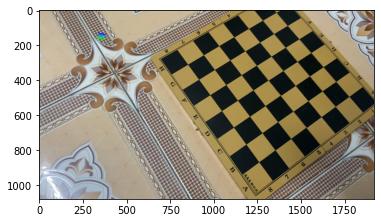

Found corners for /content/camera_cal/calibration18.jpg


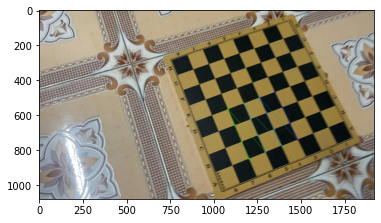

Found corners for /content/camera_cal/calibration19.jpg


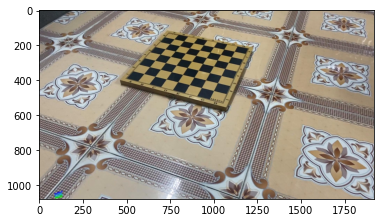

Found corners for /content/camera_cal/calibration20.jpg


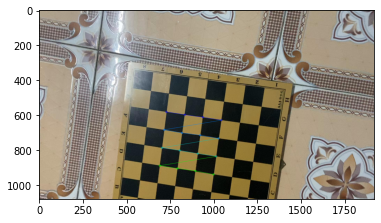

Found corners for /content/camera_cal/calibration21.jpg


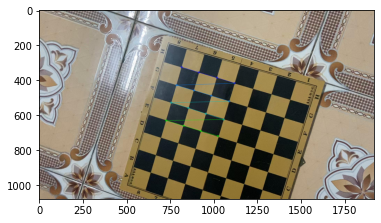

Found corners for /content/camera_cal/calibration22.jpg


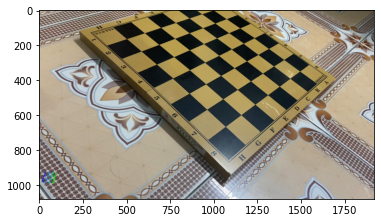

Found corners for /content/camera_cal/calibration23.jpg


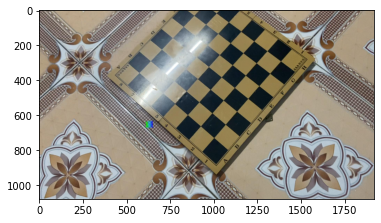

Found corners for /content/camera_cal/calibration24.jpg


Found corners for /content/camera_cal/calibration25.jpg


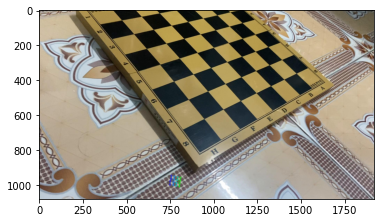

Found corners for /content/camera_cal/calibration26.jpg


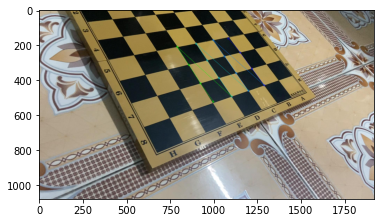

Found corners for /content/camera_cal/calibration27.jpg


Found corners for /content/camera_cal/calibration28.jpg


(array([[1.56250913e+03, 0.00000000e+00, 8.55089489e+02],
        [0.00000000e+00, 1.56600518e+03, 6.05670138e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[ 0.04612254, -0.17929943,  0.00483186, -0.01351547, -0.01657704]]))

In [ ]:
mtx, dist = calibrate_camera()
mtx, dist 

In [ ]:
def Undistort(img):
    mtx = np.array([[1.56250913e+03, 0.00000000e+00, 8.55089489e+02],
                    [0.00000000e+00, 1.56600518e+03, 6.05670138e+02],
                    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
    dist = np.array([[ 0.04612254, -0.17929943,  0.00483186, -0.01351547, -0.01657704]])
    # mtx = np.array([[1156.8779626789303, 0, 670.6087457998882],
    #                 [0, 1153.533882403008, 388.89469694242746],
    #                 [0, 0, 1]])
    # dist = np.array([[-0.24556352635221532, 0.0025643098504253064, -0.000588014374191127,
    #                     -0.00013497978780334353, -0.068520926273065]])

    h,  w = img.shape[:2]
    # newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # x, y, w, h = roi
    # dst = dst[y:y+h, x:x+w]
    
    # dst = cv2.undistort(img, mtx, dist, None, mtx)

    return dst

Text(0.5, 1.0, 'Undistorted')

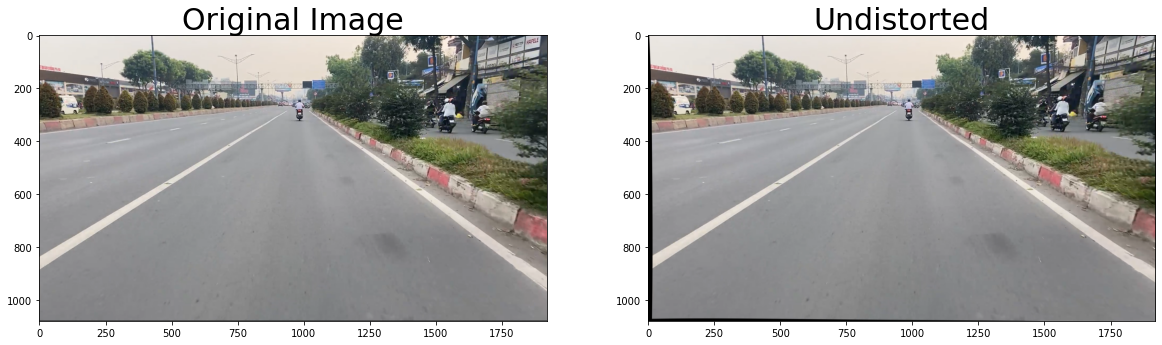

In [ ]:
img = cv2.imread('/content/straight_line.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = Undistort(img)


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted', fontsize=30)

# Thresold image


In [ ]:
def threshold_image(img, s_thresh=(190, 255), sx_thresh=(15, 255)):
    img = Undistort(img)
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # plt.imshow(scaled_sobel, cmap='gray')
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def pixel_isolation(img, lower=(200,200,200), upper=(255,255,255)):
  return cv2.inRange(Undistort(img), lower, upper)

Text(0.5, 1.0, 'Processed Image')

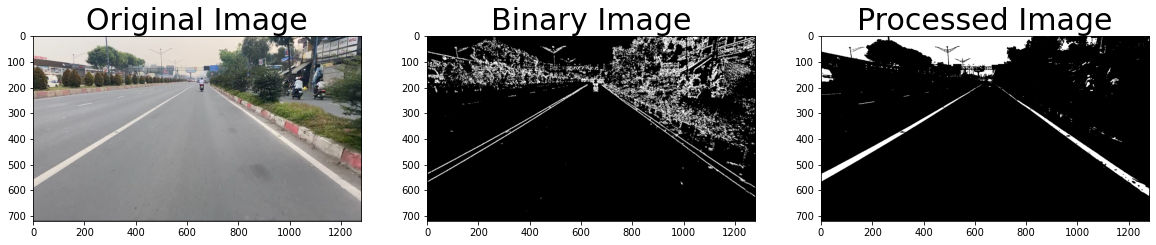

In [ ]:
img = cv2.imread('/content/straight_line1.png')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
processed_img = pixel_isolation(img)
binary_image = threshold_image(img)

# Visualize undistortion
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_image, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)
ax3.imshow(processed_img, cmap='gray')
ax3.set_title('Processed Image', fontsize=30)

# Perspective Transform

In [ ]:
def perspective_warp(img, dst_size=(1920,1080)):
  src = np.float32([(0,0.75),(0.35,0.4),(0.65,0.4),(0.95,0.75)])
  dst = np.float32([(0,1), (0, 0), (1,0), (1,1)])
  # src = np.float32(
	# 	[[200, 720],
	# 	[1100, 720],
	# 	[595, 450],
	# 	[685, 450]])
  
  # dst = np.float32(
	# 	[[300, 720],
	# 	[980, 720],
	# 	[300, 0],
	# 	[980, 0]])
  img_size = np.float32([(img.shape[1],img.shape[0])])
  src = src* img_size
  dst = dst * np.float32(dst_size)
  M = cv2.getPerspectiveTransform(src, dst)
  warped = cv2.warpPerspective(img, M, dst_size)
  return warped

def inv_perspective_warp(img, dst_size=(1920,1080)):
  src = np.float32([(0,1), (0, 0), (1,0), (1,1)])
  dst = np.float32([(0,0.75),(0.35,0.4),(0.65,0.4),(0.95,0.75)])
  # src = np.float32(
	# 	[[300, 720],
	# 	[980, 720],
	# 	[300, 0],
	# 	[980, 0]])
  # dst = np.float32(
	# 	[[200, 720],
	# 	[1100, 720],
	# 	[595, 450],
	# 	[685, 450]])

  img_size = np.float32([(img.shape[1],img.shape[0])])
  src = src* img_size
  dst = dst * np.float32(dst_size)
  M = cv2.getPerspectiveTransform(src, dst)
  warped = cv2.warpPerspective(img, M, dst_size)
  return warped

def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

In [ ]:
# def perspective_warp(img, dst_size=(1280,720)):
#   # src = np.float32([(0,0.75),(0.35,0.4),(0.65,0.4),(0.95,0.75)])
#   # dst = np.float32([(0,1), (0, 0), (1,0), (1,1)])

#   img_size = np.float32([(img.shape[1],img.shape[0])])
#   # src = np.float32(
# 	# 	[[200, 720],
# 	# 	[1100, 720],
# 	# 	[595, 450],
# 	# 	[685, 450]])
  
#   # dst = np.float32(
# 	# 	[[300, 720],
# 	# 	[980, 720],
# 	# 	[300, 0],
# 	# 	[980, 0]])
#   src = np.float32(
# 		[[0, 550],
# 		[1150, 560],
# 		[500, 250],
# 		[780, 250]])
  
#   dst = np.float32(
# 		[[300, 720],
# 		[1000, 720],
# 		[300, 0],
# 		[1000, 0]])
#   # src = src* img_size
#   # dst = dst * np.float32(dst_size)
#   M = cv2.getPerspectiveTransform(src, dst)
#   warped = cv2.warpPerspective(img, M, dst_size)
#   return warped

# def inv_perspective_warp(img, dst_size=(1280,720)):
#   # src = np.float32([(0,1), (0, 0), (1,0), (1,1)])
#   # dst = np.float32([(0,0.75),(0.35,0.4),(0.65,0.4),(0.95,0.75)])

#   img_size = np.float32([(img.shape[1],img.shape[0])])
#   # dst = np.float32(
# 	# 	[[200, 720],
# 	# 	[1100, 720],
# 	# 	[595, 450],
# 	# 	[685, 450]])
  
#   # src = np.float32(
# 	# 	[[300, 720],
# 	# 	[980, 720],
# 	# 	[300, 0],
# 	# 	[980, 0]])
#   dst = np.float32(
# 		[[0, 550],
# 		[1280, 560],
# 		[500, 250],
# 		[780, 250]])
  
#   src = np.float32(
# 		[[300, 720],
# 		[1080, 720],
# 		[300, 0],
# 		[1080, 0]])
#   # src = src* img_size
#   # dst = dst * np.float32(dst_size)
#   M = cv2.getPerspectiveTransform(src, dst)
#   warped = cv2.warpPerspective(img, M, dst_size)
#   return warped

# def get_hist(img):
#     hist = np.sum(img[img.shape[0]//2:,:], axis=0)
#     return hist

Text(0.5, 1.0, 'Inv_warped Image')

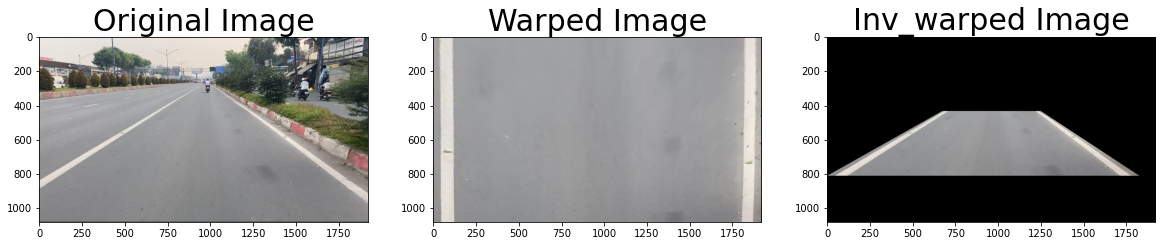

In [ ]:
img = cv2.imread('/content/straight_line.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# binary_image = threshold_image(img)
warped = perspective_warp(img)
inv_warped = inv_perspective_warp(warped)

# Visualize 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)
ax3.imshow(inv_warped, cmap='gray')
ax3.set_title('Inv_warped Image', fontsize=30)

# Detect lane

In [ ]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows=9, margin=150, minpix = 1, draw_windows=True):
    global left_a, left_b, left_c,right_a, right_b, right_c 
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img))*255

    histogram = get_hist(img)
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (100,255,255), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (100,255,255), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        
#        if len(good_right_inds) > minpix:        
#            rightx_current = np.int(np.mean([leftx_current +900, np.mean(nonzerox[good_right_inds])]))
#        elif len(good_left_inds) > minpix:
#            rightx_current = np.int(np.mean([np.mean(nonzerox[good_left_inds]) +900, rightx_current]))
#        if len(good_left_inds) > minpix:
#            leftx_current = np.int(np.mean([rightx_current -900, np.mean(nonzerox[good_left_inds])]))
#        elif len(good_right_inds) > minpix:
#            leftx_current = np.int(np.mean([np.mean(nonzerox[good_right_inds]) -900, leftx_current]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

def get_curve(img, leftx, rightx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_pos = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

def draw_lanes(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))
    
    cv2.fillPoly(color_img, np.int_(points), (0,200,255))
    inv_perspective = inv_perspective_warp(color_img)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective

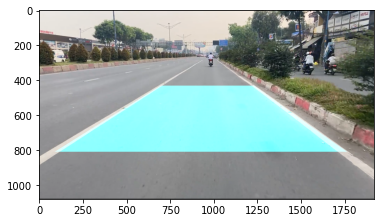

In [ ]:
img = cv2.imread('/content/straight_line.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary_image = threshold_image(img)
warped = perspective_warp(binary_image)
#%matplotlib gtk
out_img, curves, lanes, ploty = sliding_window(warped)
#plt.imshow(out_img)
# plt.plot(curves[0], ploty, color='yellow', linewidth=1)
# plt.plot(curves[1], ploty, color='yellow', linewidth=1)
# print(np.asarray(curves).shape)
# curverad=get_curve(img, curves[0],curves[1])
# print(curverad)
img_ = draw_lanes(img, curves[0], curves[1])
plt.imshow(img_, cmap='hsv')

In [ ]:
img = cv2.imread('/content/straight_line.png')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary_image = threshold_image(img)
warped = perspective_warp(binary_image)
out_img, curves, lanes, ploty = sliding_window(warped)
# curverad=get_curve(img, curves[0],curves[1])
img_ = draw_lanes(img, curves[0], curves[1])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(100, 20))
#f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=100)
ax2.imshow(warped)
ax2.set_title('Filter+Perspective Tform', fontsize=100)
ax3.imshow(out_img)
ax3.plot(curves[0], ploty, color='yellow', linewidth=30)
ax3.plot(curves[1], ploty, color='yellow', linewidth=30)
ax3.set_title('Sliding window+Curve Fit', fontsize=100)
ax4.imshow(img_)
ax4.set_title('Overlay Lanes', fontsize=100)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Output hidden; open in https://colab.research.google.com to view.

# Video Pipeline

In [ ]:
def vid_pipeline(img):
    global running_avg
    global index
    img_ = threshold_image(img)
    img_ = perspective_warp(img_)
    out_img, curves, lanes, ploty = sliding_window(img_, draw_windows=False)
    curverad =get_curve(img, curves[0], curves[1])
    lane_curve = np.mean([curverad[0], curverad[1]])
    img = draw_lanes(img, curves[0], curves[1])
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize=0.5
    # cv2.putText(img, 'Lane Curvature: {:.0f} m'.format(lane_curve), (570, 620), font, fontSize, fontColor, 2)
    # cv2.putText(img, 'Vehicle offset: {:.4f} m'.format(curverad[2]), (570, 650), font, fontSize, fontColor, 2)
    return img

In [ ]:
# !gdown --id 1EnRcY2MX4yx1jaFGe5W_niR8m5K4UGC3 -O demo.MOV

Downloading...
From: https://drive.google.com/uc?id=1EnRcY2MX4yx1jaFGe5W_niR8m5K4UGC3
To: /content/demo.MOV
100% 44.3M/44.3M [00:00<00:00, 120MB/s] 


In [ ]:
# !gdown --id 1-Jok1HZDjiIMycYabhueDer7Dsz-57IZ

Downloading...
From: https://drive.google.com/uc?id=1-Jok1HZDjiIMycYabhueDer7Dsz-57IZ
To: /content/project_video.mp4
100% 25.3M/25.3M [00:00<00:00, 93.5MB/s]


In [ ]:
!gdown --id 1EnRcY2MX4yx1jaFGe5W_niR8m5K4UGC3

Downloading...
From: https://drive.google.com/uc?id=1EnRcY2MX4yx1jaFGe5W_niR8m5K4UGC3
To: /content/demo.mov
100% 44.3M/44.3M [00:00<00:00, 164MB/s]


In [ ]:
right_curves, left_curves = [],[]
from moviepy.editor import VideoFileClip

myclip = VideoFileClip('/content/demo.mov')#.subclip(40,43)
output_vid = 'output.mp4'
clip = myclip.fl_image(vid_pipeline)
clip.write_videofile(output_vid, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|██████████| 1783/1783 [11:29<00:00,  2.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

